In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline # will be utilized to handle scaling of data AFTER it has been split into train/test by cross-validation
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [29]:
# Load flagged dataset #
dataset_flagged = pd.read_csv("flagged.csv")
X_flagged_unscaled = dataset_flagged.drop(['cls'], axis=1)
Y_flagged = dataset_flagged['cls']

We will be using cross-validation. 

In [30]:
summary_flagged_un = X_flagged_unscaled.agg(['min', 'max']).T # agg applies both the min and max function, T transposes it
summary_flagged_un.columns = ['Min Value', 'Max Value'] # rename columns

display(summary_flagged_un)

,Min Value,Max Value
Unnamed: 0,0.000000,18757.0
duration,2.000000,601404954.0
pps,0.019762,1000000.0
bps,3.557943,617000000.0
max_flowiat,2.000000,600109654.0
mean_flowiat,2.000000,60700000.0
has_active,0.000000,1.0
has_std_active,0.000000,1.0
has_fiat,0.000000,1.0
has_biat,0.000000,1.0


Looking above, we notice that we have big numbers. It'd be easier to run calculations with smaller values. We will use the StandardScaler to normalize everything before training any of the models.

For both of these models, we will first do hyperparameter tuning. 

KNN requires that we tune only the number of neighbors. We will fit multiple values for the neighbor parameter and choose the one with the highest test scores.

In [38]:
# Hyperparameter Tuning of flagged dataset for KNN. #

# Split and scale #
X_train, X_test, y_train, y_test = train_test_split(X_flagged_unscaled, Y_flagged, test_size=0.20, random_state=1, stratify=Y_flagged)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Training and testing with different values for K. #
train_score = {}
test_score = {}
best_neighbor = 0
n_neighbors = np.arange(1, 30, 1)
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train_scaled, y_train)
    train_score[neighbor]=knn.score(X_train_scaled, y_train)
    test_score[neighbor]=knn.score(X_test_scaled, y_test)

# Chooses the best value for the neighbor based on test scores. #
for key, value in test_score.items():
    if value==max(test_score.values()):
        best_neighbor = key

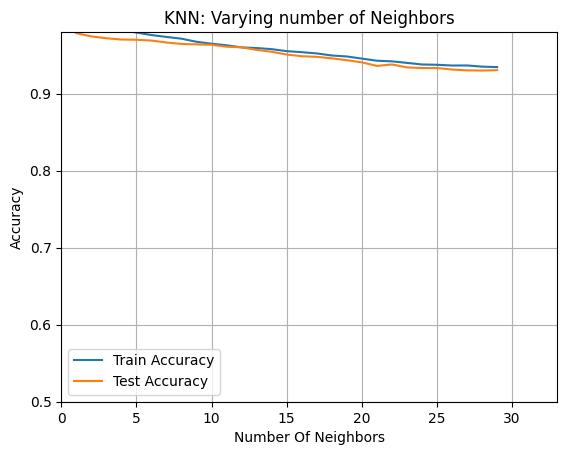

In [39]:
# Plotting the Scores. #
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, test_score.values(), label="Test Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, 33)
plt.ylim(0.50, 0.98)
plt.grid()
plt.show()

For LDA, we will tune the solver variable, the mathematical algorithm used to perform the analysis.

In [40]:
train_score = {}
test_score = {}
solvers = ['svd', 'lsqr', 'eigen']
for solver in solvers:
    lda = LinearDiscriminantAnalysis(solver=solver)
    lda.fit(X_train_scaled, y_train)
    train_score[solver]=lda.score(X_train_scaled, y_train)
    test_score[solver]=lda.score(X_test_scaled, y_test)

for key, value in test_score.items():
    if value==max(test_score.values()):
        best_solver = key


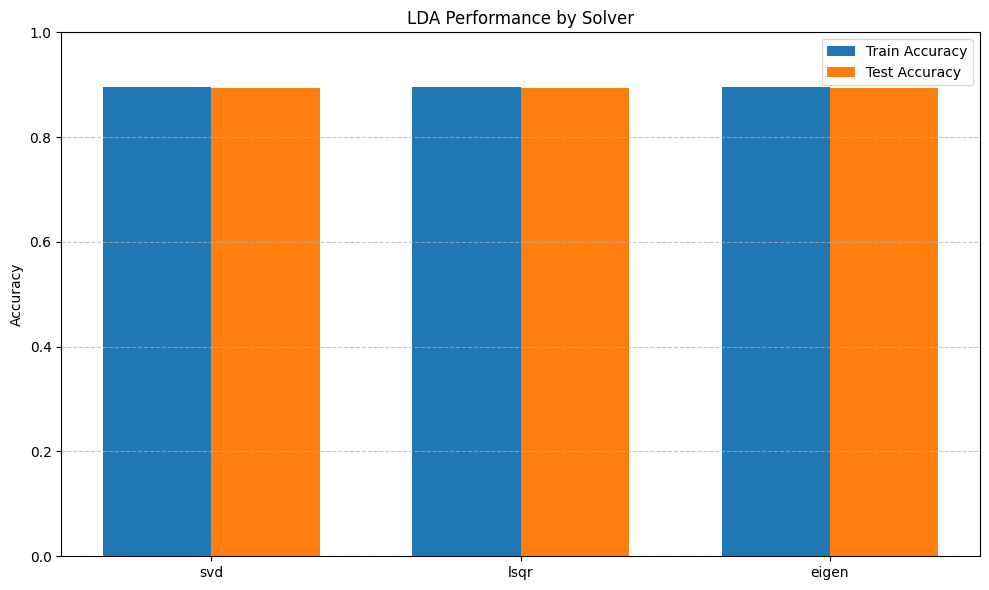

In [45]:
# Plotting the Scores. #

# Get the solver names and scores #
solver_names = list(test_score.keys())
train_scores = list(train_score.values())
test_scores = list(test_score.values())

x = np.arange(len(solver_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Accuracy')

# Add some text for labels, title and axes ticks #
ax.set_ylabel('Accuracy')
ax.set_title('LDA Performance by Solver')
ax.set_xticks(x)
ax.set_xticklabels(solver_names)
ax.legend()
ax.set_ylim(0, 1) # Set Y-Axis limit to 1

fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [47]:
# Calculate accuracy for scaled datasets. Scaling will be applied here, after separating the data #
scores_flagged = {}

# KNN #
model = KNeighborsClassifier(n_neighbors=best_neighbor)
pipeline = make_pipeline(StandardScaler(), model)
score_flagged = cross_val_score(pipeline, X_flagged_unscaled, Y_flagged, cv=10).mean()
scores_flagged['KNN'] = score_flagged

# LDA #
model = LinearDiscriminantAnalysis(solver=best_solver)
pipeline = make_pipeline(StandardScaler(), model)
score_flagged = cross_val_score(pipeline, X_flagged_unscaled, Y_flagged, cv=10).mean()
scores_flagged['LDA'] = score_flagged


Text(0, 0.5, 'Accuracy')

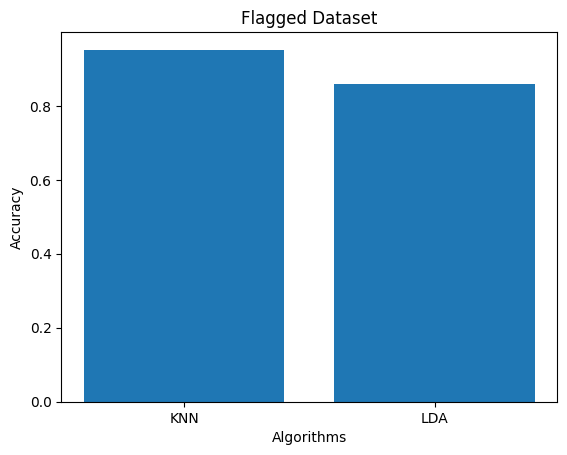

In [51]:
# Plotting the results of scaled dataset. #
plt.bar(list(scores_flagged.keys()), list(scores_flagged.values()))
plt.title("Flagged Dataset")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")